In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
from PIL import Image
from torchvision.transforms import ToTensor

class SticksDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        else:
            img = ToTensor()(img)

        annot_path = os.path.join(self.annotations_dir, self.images[idx].replace(".jpg", ".txt"))
        #print(img_path, annot_path)
        with open(annot_path, 'r') as file:
            coords = list(map(float, file.read().strip().split()))

        # Extract keypoints and convert to model format
        keypoints = [
            [coords[0], coords[1], 2],  # Stick 1 start
            [coords[2], coords[3], 2],  # Stick 1 end
            [coords[4], coords[5], 2],  # Stick 2 start
            [coords[6], coords[7], 2]   # Stick 2 end
        ]

        # Define bounding boxes around the sticks (approximate, for KeypointRCNN)
        xmin = min(coords[0], coords[2], coords[4], coords[6]) - 5
        ymin = min(coords[1], coords[3], coords[5], coords[7]) - 5
        xmax = max(coords[0], coords[2], coords[4], coords[6]) + 5
        ymax = max(coords[1], coords[3], coords[5], coords[7]) + 5
        boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)

        # Organize target data
        target = {
            'boxes': boxes,
            'labels': torch.tensor([1], dtype=torch.int64),  # Use a single class label for sticks
            'keypoints': torch.tensor([keypoints], dtype=torch.float32),
            'image_name': self.images[idx]
        }

        return img, target


In [3]:
import torchvision

# Load the pre-trained model
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)

# Replace the output layers to fit our task (1 class, 4 keypoints)
num_classes = 2  # 1 class (stick) + background
num_keypoints = 4
model.roi_heads.keypoint_predictor = torchvision.models.detection.keypoint_rcnn.KeypointRCNNPredictor(
    model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels, num_keypoints
)
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    model.roi_heads.box_predictor.cls_score.in_features, num_classes
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:02<00:00, 118MB/s] 


In [7]:
from torch.utils.data import DataLoader
import torch.optim as optim
image_dir = '/content/drive/My Drive/trainImages'
annotation_dir = '/content/drive/My Drive/annotations'

# Define data loader
train_dataset = SticksDataset(images_dir=image_dir, annotations_dir=annotation_dir)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Optimizer and training loop
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the specified device
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        #print(targets[0])
        for target in targets:
            temp = target.pop('image_name')
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {losses.item()}")


Epoch [1/10], Loss: 1.5833103656768799
Epoch [2/10], Loss: 1.3061214685440063
Epoch [3/10], Loss: 1.536836862564087
Epoch [4/10], Loss: 1.0662368535995483
Epoch [5/10], Loss: 1.5056272745132446
Epoch [6/10], Loss: 1.033776879310608
Epoch [7/10], Loss: 0.8958793878555298
Epoch [8/10], Loss: 0.9390350580215454
Epoch [9/10], Loss: 0.824546754360199
Epoch [10/10], Loss: 0.8644832372665405


In [8]:
torch.save(model, '/content/drive/My Drive/Models/PoseModelResnet50.pth')

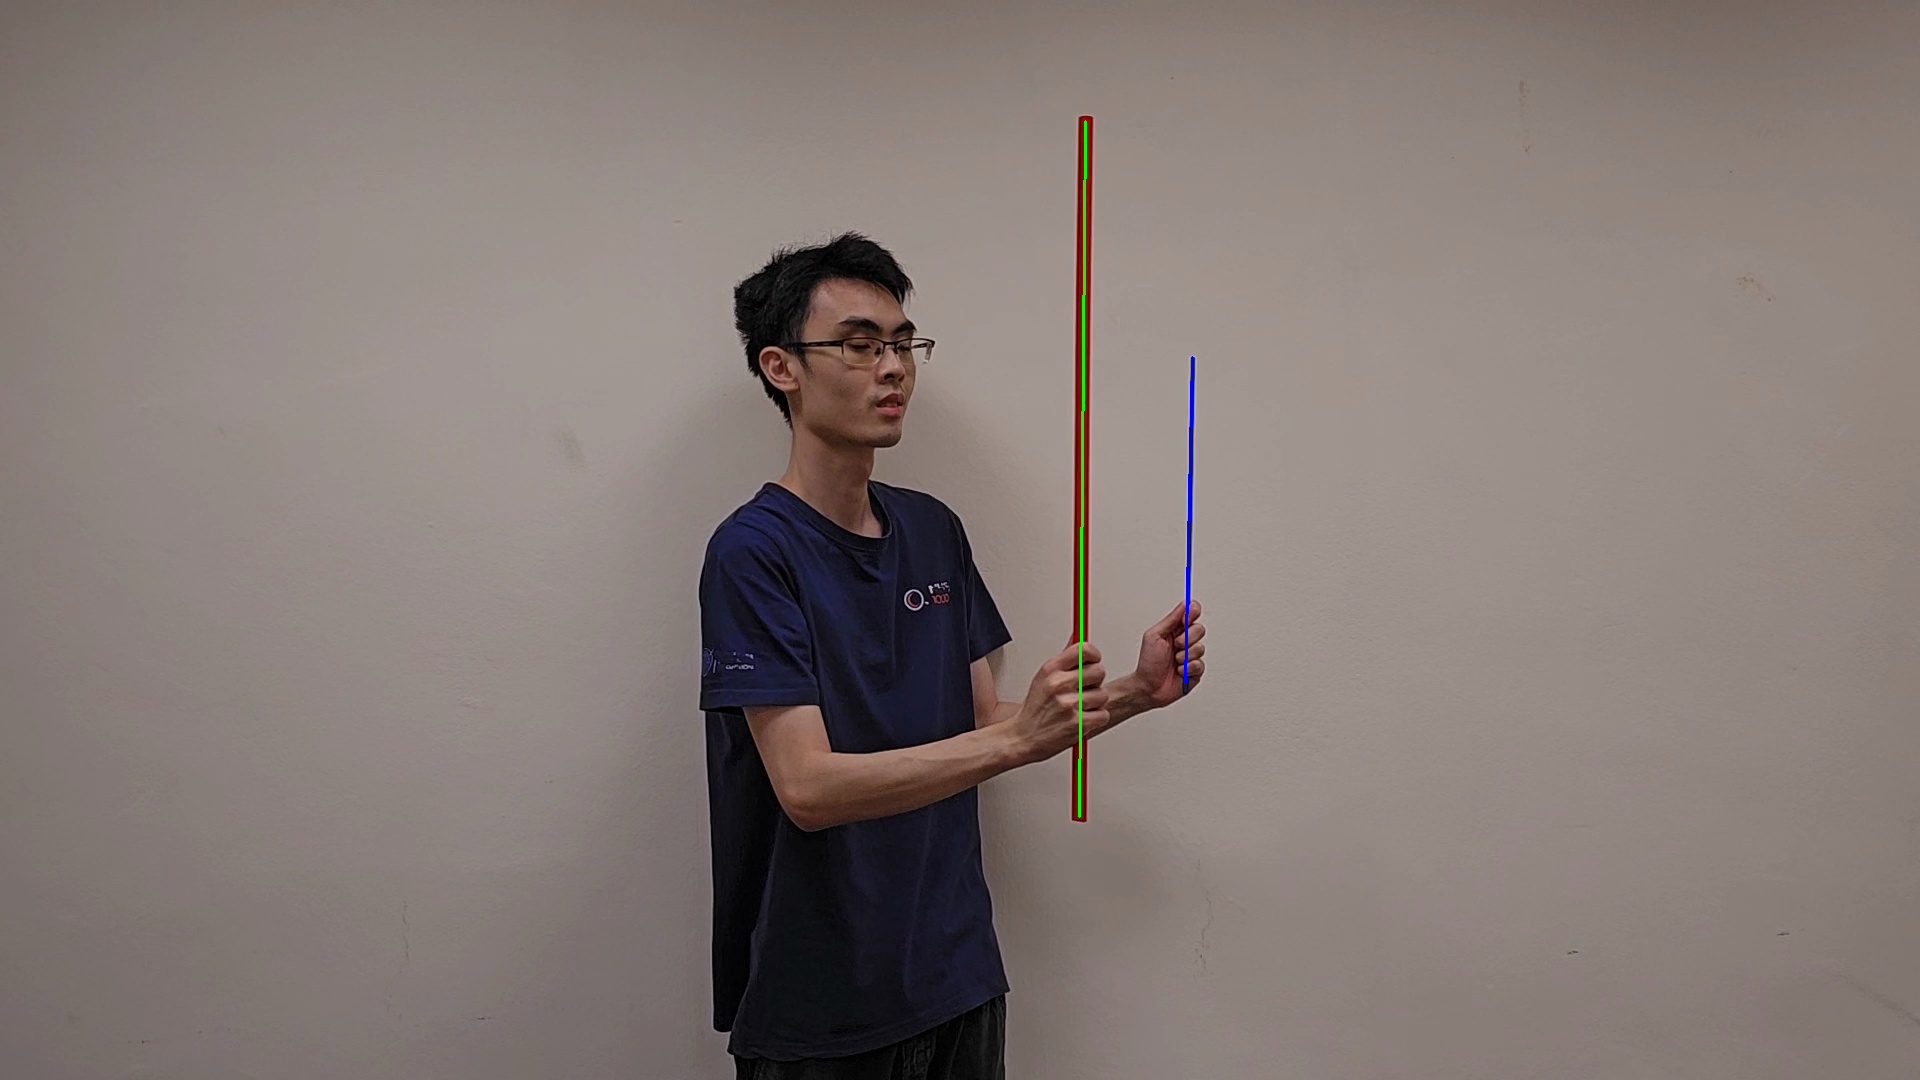

In [ ]:
import torch
import cv2
from PIL import Image
from torchvision.transforms import ToTensor
import numpy as np
from google.colab.patches import cv2_imshow
model.eval()  # Set model to evaluation mode

def draw_stick_lines(image_path, model):
    # Load image
    image = Image.open(image_path).convert("RGB")
    img_tensor = ToTensor()(image).unsqueeze(0).to(device)

    # Run inference
    with torch.no_grad():
        output = model(img_tensor)

    # Extract keypoints from the first detected object (if any)
    if len(output[0]['keypoints']) > 0:
        keypoints = output[0]['keypoints'][0].cpu().numpy()

        # Convert to numpy array and open image in OpenCV
        img_cv2 = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        # Draw lines between the endpoints for each stick
        stick_1_start = tuple(keypoints[0][:2].astype(int))  # Stick 1 start
        stick_1_end = tuple(keypoints[1][:2].astype(int))    # Stick 1 end
        stick_2_start = tuple(keypoints[2][:2].astype(int))  # Stick 2 start
        stick_2_end = tuple(keypoints[3][:2].astype(int))    # Stick 2 end

        # Draw lines on the image
        cv2.line(img_cv2, stick_1_start, stick_1_end, (0, 255, 0), thickness=2)  # Green line for Stick 1
        cv2.line(img_cv2, stick_2_start, stick_2_end, (255, 0, 0), thickness=2)  # Blue line for Stick 2

        # Display the result
        cv2_imshow(img_cv2)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("No sticks detected in the image.")

# Test the function
draw_stick_lines("frame_3274.jpg", model)

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the specified device
#model.to(device)

#model = torch.load('/content/drive/My Drive/Models/PoseModel.pth', weights_only=False, map_location=torch.device('cpu'))
model = torch.load('/content/drive/My Drive/Models/PoseModelResnet50.pth', weights_only=False)
model.to(device)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

Time required to show the output: 0.10918235778808594 seconds


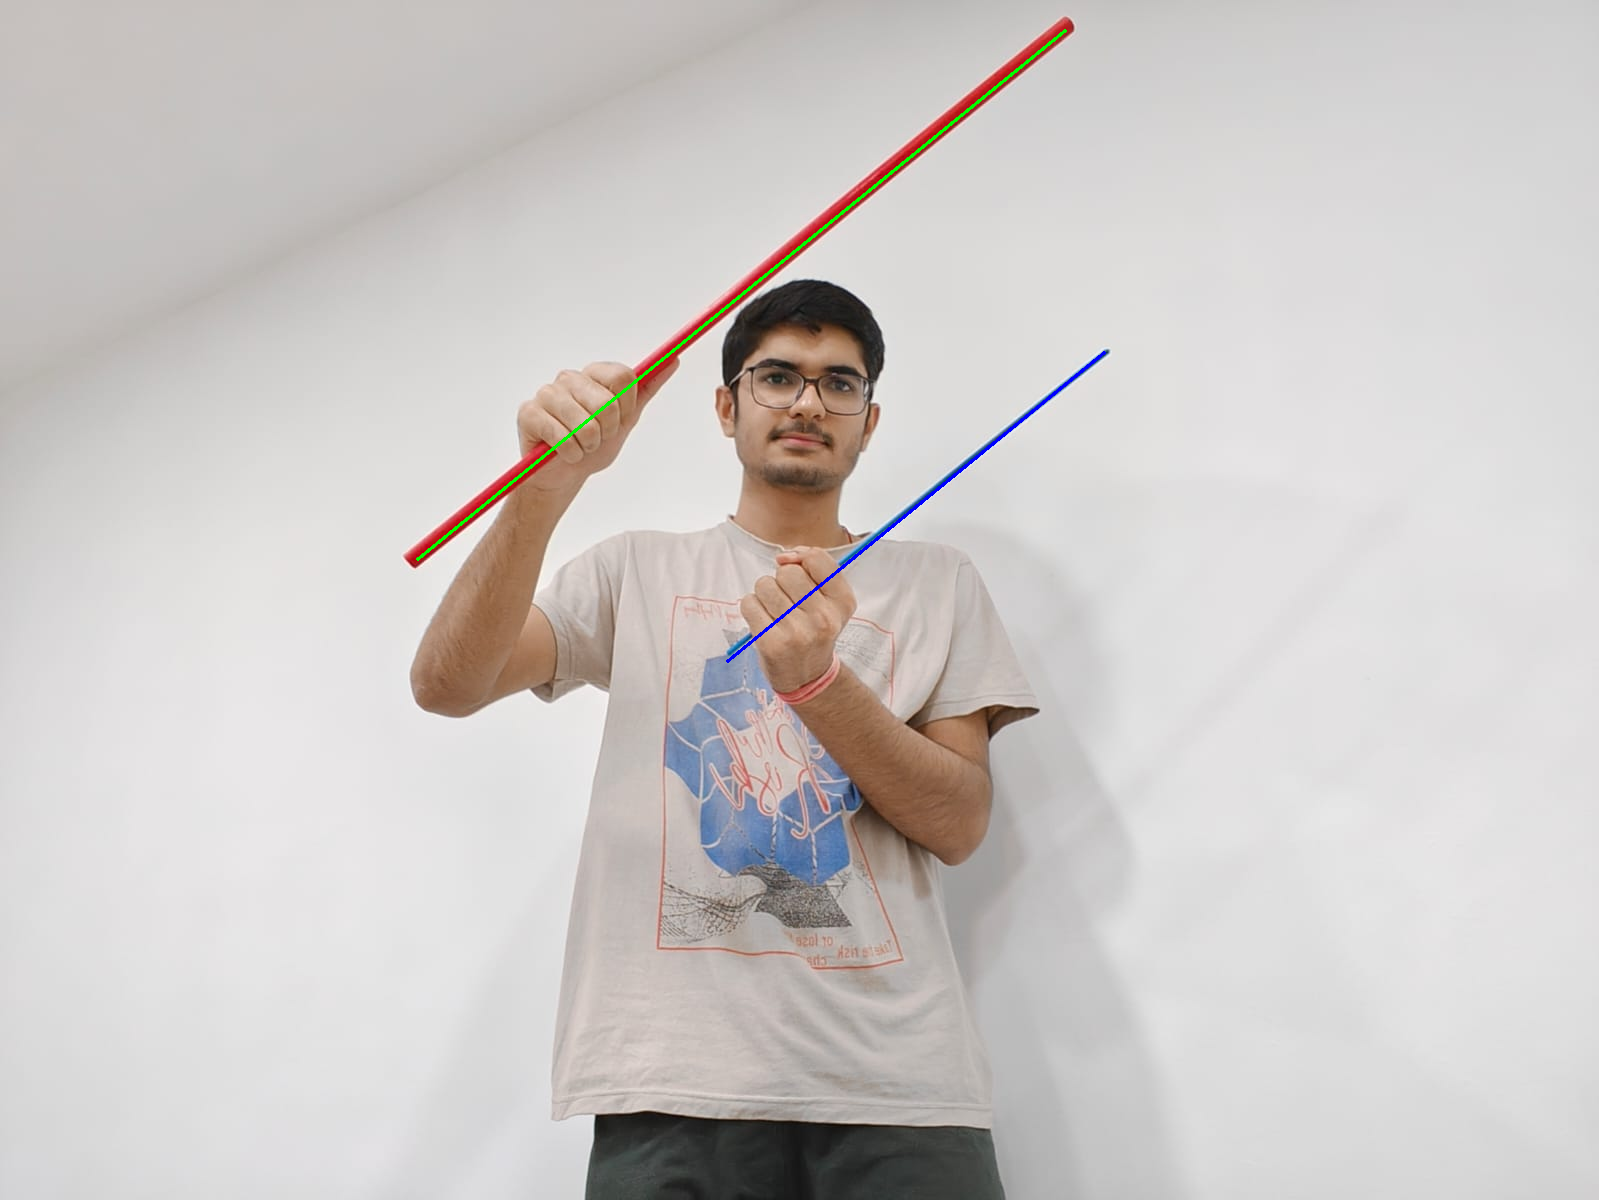

In [10]:
import torch
import cv2
from PIL import Image
from torchvision.transforms import ToTensor
import numpy as np
from google.colab.patches import cv2_imshow
import torch.quantization as quantization
import time

model.eval()  # Set the model to evaluation mode
#model1 = quantization.quantize_dynamic(model1, {torch.nn.Linear}, dtype=torch.qint8)


def draw_stick_lines(image_path, model):
    # Load image
    image = Image.open(image_path).convert("RGB")
    img_tensor = ToTensor()(image).unsqueeze(0).to(device)

    start_time = time.time()

    # Run inference
    with torch.no_grad():
        output = model(img_tensor)

    end_time = time.time()
    time_taken = end_time - start_time
    print("Time required to show the output:", time_taken, "seconds")

    # Extract keypoints from the first detected object (if any)
    if len(output[0]['keypoints']) > 0:
        keypoints = output[0]['keypoints'][0].cpu().numpy()

        # Convert to numpy array and open image in OpenCV
        img_cv2 = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        # Draw lines between the endpoints for each stick
        stick_1_start = tuple(keypoints[0][:2].astype(int))  # Stick 1 start
        stick_1_end = tuple(keypoints[1][:2].astype(int))    # Stick 1 end
        stick_2_start = tuple(keypoints[2][:2].astype(int))  # Stick 2 start
        stick_2_end = tuple(keypoints[3][:2].astype(int))    # Stick 2 end

        # Draw lines on the image
        cv2.line(img_cv2, stick_1_start, stick_1_end, (0, 255, 0), thickness=2)  # Green line for Stick 1
        cv2.line(img_cv2, stick_2_start, stick_2_end, (255, 0, 0), thickness=2)  # Blue line for Stick 2

        # Display the result
        cv2_imshow(img_cv2)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("No sticks detected in the image.")

# Test the function /content/frame_0000_20240825_145846_1.jpeg
#draw_stick_lines("/content/drive/My Drive/stick_endpoint_images/frame_0658.jpg", model)
#for i in range(1,10):
#    draw_stick_lines("image"+str(i)+".jpeg", model)
draw_stick_lines("image7.jpeg", model)

In [9]:
import torch
import cv2
import numpy as np
from torch.utils.data import DataLoader
import math

# Function to evaluate model on the test set
def evaluate_model(model, test_loader, iou_threshold=0.5):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    total_true_positives = 0
    total_false_positives = 0
    total_ground_truths = 0

    total_correct_detections = 0
    total_ground_truths = 0
    ImageCount=0
    missed_endpoints = []
    missed_labels = {1:0,2:0,3:0,4:0}

    unsuccessful_images =[]
    with torch.no_grad():
        for images, targets in test_loader:
            target_dict=[]
            images = [img.to(device) for img in images]
            for target in targets:
                #print(target)
                target_dict.append(target['image_name'])
                temp = target.pop('image_name')
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

            # Run inference
            predictions = model(images)
            ImageCount += len(images)
            for i in range(len(images)):
                #print(i)
                # Get predicted and ground truth boxes
                predicted_boxes = predictions[i]['boxes'].cpu().numpy()
                predicted_labels = predictions[i]['labels'].cpu().numpy()
                predicted_keypoints = predictions[i]['keypoints'].cpu().numpy()

                ground_truth_boxes = targets[i]['boxes'].cpu().numpy()
                ground_truth_labels = targets[i]['labels'].cpu().numpy()
                ground_truth_keypoints = targets[i]['keypoints'].cpu().numpy()

                #print("here",ground_truth_boxes, predicted_boxes)
                # Count the number of ground truth boxes


                # Match predictions with ground truths using IoU
                for j, gt_key in enumerate(ground_truth_keypoints):
                    total_ground_truths += len(gt_key)
                    flag=0
                    #for k, pred_key in enumerate(predicted_keypoints):
                    for l in range(len(gt_key)):
                        if (math.sqrt((predicted_keypoints[j][l][0] - gt_key[l][0])**2 + (predicted_keypoints[j][l][1] - gt_key[l][1])**2)) < 100:
                            total_correct_detections += 1
                        else:
                            unsuccessful_images.append([target_dict[i],l])
                    # if flag == 0:
                    #     missed_endpoints.append([target_dict[i] , ground_truth_labels[j]])
                    #     missed_labels[ground_truth_labels[j]] +=1
                    #     count+=1
                    #     total_ground_truths -= 1

    # Calculate accuracy
    print(ImageCount)
    print(total_correct_detections, total_ground_truths)
    accuracy = total_correct_detections / total_ground_truths if total_ground_truths > 0 else 0
    print(f"Accuracy: {accuracy:.4f}")
    print(unsuccessful_images)
    # print("count", count)
    # print(missed_labels)
    # print(missed_endpoints)

images_dir = '/content/drive/My Drive/stick_endpoint_images'
annotations_dir = '/content/drive/My Drive/annotations'

test_dataset = SticksDataset(images_dir=images_dir, annotations_dir=annotations_dir, transform=None)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Step 3: Evaluate the Model
evaluate_model(model, test_loader)


378
1405 1512
Accuracy: 0.9292
[['frame_0702.jpg', 2], ['frame_0702.jpg', 3], ['frame_0738.jpg', 2], ['frame_0742.jpg', 2], ['frame_0894.jpg', 2], ['frame_0898.jpg', 2], ['frame_0902.jpg', 2], ['frame_0910.jpg', 2], ['frame_0914.jpg', 2], ['frame_0918.jpg', 2], ['frame_0922.jpg', 2], ['frame_0926.jpg', 2], ['frame_0930.jpg', 2], ['frame_0934.jpg', 2], ['frame_0938.jpg', 2], ['frame_0942.jpg', 2], ['frame_0946.jpg', 2], ['frame_0950.jpg', 2], ['frame_0978.jpg', 3], ['frame_0990.jpg', 0], ['frame_0998.jpg', 3], ['frame_1002.jpg', 3], ['frame_1006.jpg', 0], ['frame_1038.jpg', 3], ['frame_1042.jpg', 3], ['frame_1046.jpg', 3], ['frame_1110.jpg', 3], ['frame_1130.jpg', 0], ['frame_1134.jpg', 0], ['frame_2762.jpg', 0], ['frame_2766.jpg', 0], ['frame_2806.jpg', 3], ['frame_2810.jpg', 0], ['frame_2814.jpg', 0], ['frame_3050.jpg', 3], ['frame_3142.jpg', 0], ['frame_3162.jpg', 0], ['frame_3274.jpg', 1], ['frame_3278.jpg', 1], ['frame_3286.jpg', 3], ['frame_3290.jpg', 2], ['frame_3290.jpg', 3], ['